# Load basic config

In [8]:
import math
from qubecalib import Qube

In [2]:
QUBE = Qube(config_file_name='qube_riken_1-10.yml')
QUBE.config

{'bitfile': '0d5ea1.bit',
 'ipfpga': '10.1.0.28',
 'iplsi': '10.5.0.28',
 'macfpga': '00-0A-35-0D-5E-A1',
 'maclsi': '00-1B-1A-EE-01-27',
 'type': 'A'}

In [3]:
[v.status for k, v in QUBE.port.items()]

['RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 'RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz ',
 'RF = 8000.000 MHz LO =  9000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 'RF = 13000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 'RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 'RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 'RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz ',
 'RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive']

In [4]:
QUBE.config_fpga()

'\n****** Vivado v2020.1 (64-bit)\n  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020\n  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020\n    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.\n\nsource ./adi_api_mod/utils/config.tcl\n# open_hw_manager\n# connect_hw_server -allow_non_jtag\nINFO: [Labtools 27-2285] Connecting to hw_server url TCP:localhost:3121\nINFO: [Labtools 27-2222] Launching hw_server...\nINFO: [Labtools 27-2221] Launch Output:\n\n****** Xilinx hw_server v2020.1\n  **** Build date : May 27 2020 at 20:33:44\n    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.\n\n\nINFO: [Labtools 27-3415] Connecting to cs_server url TCP:localhost:3042\nINFO: [Labtools 27-3417] Launching cs_server...\nINFO: [Labtools 27-2221] Launch Output:\n\n\n****** Xilinx cs_server v2020.1.0\n  **** Build date : May 14 2020-10:10:29\n    ** Copyright 2017-2020 Xilinx, Inc. All Rights Reserved.\n\n\n\n# open_hw_target\nINFO: [Labtoolstcl 44-466] Opening hw_target localhos

# Readout(P0) -> Readin(P1)

In [5]:
from collections import namedtuple
from e7awgsw import AWG, AwgCtrl, CaptureCtrl, CaptureModule, CaptureParam, DspUnit, SinWave, IqWave
from e7awgsw import WaveSequence
import numpy as np


ADDITIONAL_CAPTURE_DELAY = 0 # cpature words = cycyles@125MHz 


wave_params = namedtuple(
    'WaveParams',
    ('num_wait_words',
     'ctrl_freq',
     'ctrl_wave_len',
     'readout_freq',
     'readout_wave_len',
     'readout_blank_len',
     'num_chunk_repeats',
     'ctrl_amp',
     'readout_amp',
    ))


awg_list = namedtuple(
    'AwgList',
    ('ctrl_awg_0',
     'ctrl_awg_1',
     'readout_awg_0',
     'readout_awg_1'))


AWG_LIST = awg_list(
    ctrl_awg_0 = AWG.U11,
    ctrl_awg_1 = AWG.U0,
    readout_awg_0 = AWG.U15,
    readout_awg_1 = AWG.U2
)

def set_trigger_awg(cap_ctrl, awg, capture_modules):
    for cap_mod_id in capture_modules:
        cap_ctrl.select_trigger_awg(cap_mod_id, awg)
        cap_ctrl.enable_start_trigger(*CaptureModule.get_units(cap_mod_id))






def set_wave_sequence(awg_ctrl, params):
    
    def gen_cos_wave(freq, num_cycles, amp, sampling_rate):
        freq = freq * 1e6
        i_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp, phase = math.pi / 2).gen_samples(sampling_rate)
        q_samples = SinWave(num_cycles = num_cycles, frequency = freq, amplitude = amp).gen_samples(sampling_rate)
        return (i_samples, q_samples)

    def gen_ctrl_wave_samples():
        num_cycles = params.ctrl_freq * params.ctrl_wave_len * 1e-3
        return gen_cos_wave(params.ctrl_freq, num_cycles, params.ctrl_amp, AwgCtrl.SAMPLING_RATE)

    def gen_ctrl_wave_seq(params, num_all_samples, i_samples, q_samples):
        iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
        num_blank_samples = num_all_samples - len(iq_samples)
        num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

        wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
        wave_seq.add_chunk(
            iq_samples = iq_samples,
            num_blank_words = num_blank_words, 
            num_repeats = params.num_chunk_repeats
        )
        return wave_seq
    
    def gen_readout_wave_samples(params, num_pre_blank_samples):
        num_cycles = params.readout_freq * params.readout_wave_len * 1e-3
        i_samples, q_samples = gen_cos_wave(params.readout_freq, num_cycles, params.readout_amp, AwgCtrl.SAMPLING_RATE)
        i_samples = [0] * num_pre_blank_samples + i_samples
        q_samples = [0] * num_pre_blank_samples + q_samples
        return (i_samples, q_samples)

    def gen_readout_wave_seq(params, i_samples, q_samples):
        iq_samples = IqWave.convert_to_iq_format(i_samples, q_samples, WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK)
        # I/Q サンプルに付加された 0 データの分 readout 波形のブランクを短くする
        num_added_samples = len(iq_samples) - len(i_samples)
        num_blank_samples = max(
            int(AwgCtrl.SAMPLING_RATE * params.readout_blank_len / 1e3) - num_added_samples, 0)
        num_blank_words = num_blank_samples // WaveSequence.NUM_SAMPLES_IN_AWG_WORD

        wave_seq = WaveSequence(num_wait_words = params.num_wait_words, num_repeats = 1)
        wave_seq.add_chunk(
            iq_samples = iq_samples,
            num_blank_words = num_blank_words, 
            num_repeats = params.num_chunk_repeats
        )
        return wave_seq
    
    ctrl_i_samples, ctrl_q_samples = gen_ctrl_wave_samples() # サンプル作成
    ro_i_samples, ro_q_samples = gen_readout_wave_samples(params, len(ctrl_i_samples)) # サンプル作成

    
    ro_wave_seq = gen_readout_wave_seq(params, ro_i_samples, ro_q_samples) # 波形シーケンス作成
    ctrl_wave_seq = gen_ctrl_wave_seq(
        params, ro_wave_seq.chunk(0).num_samples, ctrl_i_samples, ctrl_q_samples)

    # control 波形と readout 波形の長さが一致することを確認
    assert ctrl_wave_seq.num_all_words == ro_wave_seq.num_all_words

    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_0, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.ctrl_awg_1, ctrl_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_0, ro_wave_seq)
    awg_ctrl.set_wave_sequence(AWG_LIST.readout_awg_1, ro_wave_seq)
    return {
        AWG_LIST.ctrl_awg_0 : ctrl_wave_seq,
        AWG_LIST.ctrl_awg_1 : ctrl_wave_seq,
        AWG_LIST.readout_awg_0 : ro_wave_seq,
        AWG_LIST.readout_awg_1 : ro_wave_seq
    }


def set_capture_params(cap_ctrl, ctrl_wave_seq, ro_wave_seq, capture_units):
    
    def gen_capture_param(ctrl_wave_seq, ro_wave_seq):
        capture_param = CaptureParam()
        capture_param.num_integ_sections = ro_wave_seq.chunk(0).num_repeats # 積算区間数

        # readout 波形の長さから, 追加で 1us キャプチャするためのキャプチャワード数を計算
        additional_capture_words = int(1e-6 * CaptureCtrl.SAMPLING_RATE) // CaptureParam.NUM_SAMPLES_IN_ADC_WORD
        additional_capture_words = min(additional_capture_words, ro_wave_seq.chunk(0).num_blank_words - 1)

        sum_section_len = ro_wave_seq.chunk(0).num_words - ro_wave_seq.chunk(0).num_blank_words + additional_capture_words
        num_blank_words = ro_wave_seq.chunk(0).num_words - sum_section_len
        capture_param.add_sum_section(sum_section_len, num_blank_words)
        capture_param.sum_start_word_no = 0
        capture_param.num_words_to_sum = CaptureParam.MAX_SUM_SECTION_LEN
        capture_param.sel_dsp_units_to_enable(DspUnit.INTEGRATION)
        capture_param.capture_delay = ctrl_wave_seq.num_wait_words + ctrl_wave_seq.chunk(0).num_wave_words
        capture_param.capture_delay += ADDITIONAL_CAPTURE_DELAY
        # readout 波形のサンプル数とキャプチャするサンプル数が一致することを確認
        assert ro_wave_seq.num_all_samples == capture_param.num_samples_to_process
        return capture_param

    capture_param = gen_capture_param(ctrl_wave_seq, ro_wave_seq)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)




def get_capture_data(cap_ctrl, capture_units):
    capture_unit_to_capture_data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_id)
        capture_unit_to_capture_data[capture_unit_id] = cap_ctrl.get_capture_data(capture_unit_id, num_captured_samples)
    return capture_unit_to_capture_data


def check_err(awg_ctrl, cap_ctrl, awgs, capture_units):
    awg_to_err = awg_ctrl.check_err(*awgs)
    for awg_id, err_list in awg_to_err.items():
        print(awg_id)
        for err in err_list:
            print('    {}'.format(err))
    
    cap_unit_to_err = cap_ctrl.check_err(*capture_units)
    for cap_unit_id, err_list in cap_unit_to_err.items():
        print('{} err'.format(cap_unit_id))
        for err in err_list:
            print('    {}'.format(err))

def rabi_meas(wparams):

    capture_modules = QUBE.port[1].adc.caps + QUBE.port[12].adc.caps
    capture_units = CaptureModule.get_units(*capture_modules)

    cap_ctrl = CaptureCtrl(QUBE.config['ipfpga'])
    awg_ctrl = AwgCtrl(QUBE.config['ipfpga'])

    # 初期化
    awg_ctrl.initialize(*AWG_LIST)
    cap_ctrl.initialize(*capture_units)

    # トリガ AWG の設定
    set_trigger_awg(cap_ctrl, AWG_LIST.ctrl_awg_0, capture_modules)

    # 波形シーケンスの設定
    awg_to_wave_sequence = set_wave_sequence(awg_ctrl, wparams)

    # キャプチャパラメータの設定
    set_capture_params(
        cap_ctrl,
        awg_to_wave_sequence[AWG_LIST.ctrl_awg_0],
        awg_to_wave_sequence[AWG_LIST.readout_awg_0],
        capture_units)

    # 波形送信スタート
    awg_ctrl.start_awgs(*AWG_LIST)

    # 波形送信完了待ち
    awg_ctrl.wait_for_awgs_to_stop(5, *AWG_LIST)

    # キャプチャ完了待ち
    cap_ctrl.wait_for_capture_units_to_stop(5, *capture_units)

    # エラーチェック
    check_err(awg_ctrl, cap_ctrl, AWG_LIST, capture_units)

    # キャプチャデータ取得
    return get_capture_data(cap_ctrl, capture_units)


In [609]:
np.linspace(10, 320, 63)

array([ 10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
        65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110., 115.,
       120., 125., 130., 135., 140., 145., 150., 155., 160., 165., 170.,
       175., 180., 185., 190., 195., 200., 205., 210., 215., 220., 225.,
       230., 235., 240., 245., 250., 255., 260., 265., 270., 275., 280.,
       285., 290., 295., 300., 305., 310., 315., 320.])

In [6]:
nco_mhz, awg_mhz = QUBE.port[0].set_freq(9217.5, 8000)
print(nco_mhz, awg_mhz)
#QUBE.port[0].upconv.vatt = 0x380
QUBE.port[0].upconv.vatt = 0x800
QUBE.port[1].adc.nco.freq = nco_mhz
nco_mhz, awg_mhz = QUBE.port[5].set_freq(7556.5, 9000)
print(nco_mhz, awg_mhz)
QUBE.port[5].dac.nco.freq = nco_mhz
QUBE.port[5].upconv.vatt = 0x7b0
#print(10109.5 + 906.25 - 11000)

print(QUBE.port[0].status)
print(QUBE.port[1].status)
print(QUBE.port[5].status)

1203.125 14.375
1437.5 6.0
RF = 9203.125 MHz LO =  8000    MHz IF = 1203.125 MHz LSB/USB: USB MODE AWG: Inactive
RF = 9203.125 MHz LO =  8000    MHz IF = 1203.125 MHz 
RF = 7562.500 MHz LO =  9000    MHz IF = 1437.500 MHz LSB/USB: LSB MODE AWG: Inactive


In [662]:
# np.linspace(10, 640, 631)

100 100


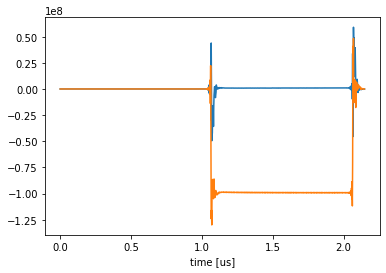

In [9]:
rslt = {}

#for c in np.linspace(10, 320, 63):
#for c in np.linspace(10, 640, 631):
for c in [100]:

    wparams = wave_params(
        num_wait_words = 0,
        ctrl_freq = 6, # MHz
        ctrl_wave_len = c, # ns
        readout_freq = 14.375, # MHz,
        readout_wave_len = 1000, # ns,
        readout_blank_len = 0.1, # ms
        num_chunk_repeats = 10000, # 積算回数
        ctrl_amp = 32767, # 17500 -> 81.3 mV
        readout_amp = 32767,
    )
    
    print(c, end=' ', flush=True)
    d = rabi_meas(wparams)

    rslt[c] = d
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    #s = slice(400,450)
    s = slice(0,-1)
    a = np.array(d[4])
    v = a[:,0] + 1j * a[:,1]
    time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
    w = v * np.exp(-1j*2*np.pi*wparams.readout_freq*(time + c))
    print(c)
    plt.plot(time[s], np.real(w[s]))
    plt.plot(time[s], np.imag(w[s]))
    plt.xlabel('time [us]')
    plt.show()

In [617]:
import pickle

with open('HandaiExpRabi202204211600.pickle', 'wb') as f:
    pickle.dump(rslt, f)

(-400000.0, 400000.0)

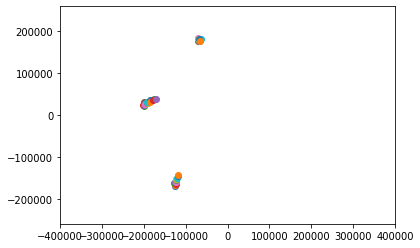

In [651]:
%matplotlib inline
import matplotlib.pyplot as plt

for k, d in rslt.items():
    s = slice(500,900)
    #s = slice(0,-1)
    a = np.array(d[4])
    v = a[:,0] + 1j * a[:,1]
    time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
    w = v * np.exp(-1j*2*np.pi*wparams.readout_freq*(time - k*1e-3))
    plt.plot(np.real(w[s].mean()), np.imag(w[s].mean()), 'o')
plt.axis('equal')
plt.xlim(-4e+5, 4e+5)
plt.ylim(-4e+5, 4e+5)


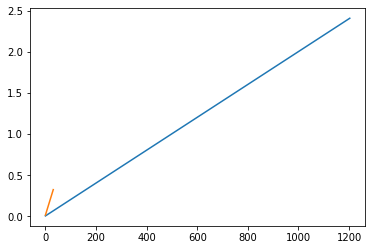

In [654]:
plt.plot(time)
plt.plot(np.array(list(rslt))*1e-3)